# CNN training

In [74]:
import os
import re
import pdb
import copy
import random
import datetime
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pandas as pd

import PIL
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import shuffle
import sklearn

from __future__ import print_function
#import keras
from tensorflow import keras
import keras.preprocessing
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend


Tensorflow version 2.2.0


In [14]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functions

In [15]:
def showDateTime():
    time_stamp = datetime.datetime.now()
    print(time_stamp.strftime('%Y.%m.%d-%H:%M:%S'))

In [16]:
def fileToList(file_name):
    result_list = [] 
    fp = open(file_name)
    for row in fp:
        row = row.strip()
        row = row.replace("\"","")
        row = re.split('\t',row)
        #row = re.split(r'[;,\s]\s*', row)
        result_list.append(row)
    fp.close()  
    return result_list 

In [17]:
def output_to_file(results,file_name):
#    path = os.getcwd() 
    path = os.path.dirname(file_name)

    if not os.path.exists(path):
        os.mkdir(path)

#    file_name = path + '/' + file_name
    fp = open(file_name,'w')
    if type(results) == list:
        for result_line in results:
            if type(result_line) != list:
                fp.write(str(result_line))
            else:
                for each_one in result_line:
                    fp.write(str(each_one))
                    fp.write('\t')
            fp.write('\n')

    elif type(results) == dict:
        for key in results.keys():
            for result_line in results[key]:
                for each_one in result_line:
                    fp.write(str(each_one))
                    fp.write('\t')
                fp.write('\n')
    elif type(results) == np.ndarray:
        np.savetxt(file_name, results, fmt='%s', delimiter='\t')
    else:
        print ('unsupport results type!')
    print ('The variable has already output to %s'%file_name)
    fp.close()

In [18]:
def loadImgs(cnv_list, img_width, img_height):
    cnv_np = np.zeros((len(cnv_list), img_width, img_height, 3))
    for index, each_cnv in enumerate(cnv_list):
        if index % 1000 == 1:
            time_stamp = datetime.datetime.now()
            time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
            print("[%s] Processing %d ..."%(time_str, index))
        cnv_img = resizeCropImg(each_cnv, img_width, img_height)
        cnv_np[index] = tf.keras.preprocessing.image.img_to_array(cnv_img)
    time_stamp = datetime.datetime.now()
    time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
    print("[%s] Done %d."%(time_str, index))
    return cnv_np

In [19]:
def recall_m(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + keras.backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+keras.backend.epsilon()))

#ref: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [20]:
def cnn_model(model_name, nClasses):
    if model_name == "CNN_model":
        model = Sequential()
        # The first two layers with 32 filters of window size 3x3
        model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(nClasses, activation='softmax'))
        
        #opt = keras.optimizers.Adam(learning_rate=0.01)
        #The learning rate. Defaults to 0.001
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=['accuracy', f1_m, precision_m, recall_m])
        return model
    
    elif model_name == "MobileNet_v1":
        model = tf.keras.applications.MobileNet(
                    input_shape=None,
                    alpha=1.0,
                    depth_multiplier=1,
                    dropout=0.001,
                    include_top=True,
                    weights="imagenet",
                    input_tensor=None,
                    pooling=None,
                    classes=1000,
                    classifier_activation="softmax"
                )
        ## self added FC layer        
        new_model = Sequential()
        new_model.add(model)
        new_model.add(Flatten())
        new_model.add(Dense(512,activation='relu'))
        new_model.add(Dropout(0.5))
        new_model.add(Dense(nClasses, activation='softmax'))

        new_model.compile(loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
        return new_model
    
    elif model_name == 'ResNet50':
        model = tf.keras.applications.ResNet50(
                include_top=True,
                weights="imagenet",
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000
            )
        ## self added FC layer        
        new_model = Sequential()
        new_model.add(model)
        new_model.add(Flatten())
        new_model.add(Dense(512,activation='relu'))
        new_model.add(Dropout(0.5))
        new_model.add(Dense(nClasses, activation='softmax'))

        new_model.compile(loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
        return new_model
    
    else:
        print("[Error] No this model%s:"%model_name)
        pdb.set_trace()

In [21]:
def pred_roc_data(model, img, label_one_hot):
    pred_keras = model.predict(img).ravel() # ravel(): Flatten the array
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(label_one_hot.ravel(), pred_keras, drop_intermediate=False) 
    auc_keras = auc(fpr_keras, tpr_keras)
    return fpr_keras, tpr_keras, thresholds_keras, auc_keras

In [22]:
def output_model_metrics(model_name, loss, accuracy, f1_score, precision, recall, output_file):
    model_metric_list = []
    model_metric_list.append(model_name)
    model_metric_list.append(["loss:", loss]) 
    model_metric_list.append(["accuracy:", accuracy])
    model_metric_list.append(["precision:", precision])
    model_metric_list.append(["recall:", recall])
    model_metric_list.append(["f1_score:", f1_score])
    output_to_file(model_metric_list, output_file)

In [23]:
# image functions
def loadImg(img_file):
    img = Image.open(img_file)
    img = img.convert("RGB")
    return img

def img2Numpy(img):
    return np.array(img)

def loadImg2Numpy(img_file):
    img = Image.open(img_file)
    img = img.convert("RGB")
    return np.array(img)

def resizeCropImg(image, target_width, target_height):
    width, height = image.size
    left   = width*0.12
    top    = height*0.12
    right  = width*0.88
    bottom = height*0.88
    image = image.crop((left, top, right, bottom))
    image = image.resize((target_width, target_height)) # resize will effect the color change function. don't know why.
#     image = image.convert("RGB")
    return image

def changeImgColor(img, old_color, new_color):
    img_data = img.getdata()
    new_image_list = []
    for item in img_data:
        if item == old_color:
            item = new_color
        new_image_list.append(item)
    img_np = np.array(new_image_list)
    img_np = img_np.reshape(img.size[0],img.size[1],3)
    return img_np

def changeImgColor_bak(img_np, old_color, new_color):
    img = Image.open(img_file)
    img = img.convert("RGB")
    img_data = img.getdata()
    new_image_list = []
    for item in img_data:
        if item == old_color:
            item = new_color
        new_image_list.append(item)
    new_img_np = np.array(new_image_list).reshape(img.size[0], img.size[1], 3)
    return new_img_np

def showImg(img_data):
    if type(img_data) is list or type(img_data) is str:
        image = tf.keras.preprocessing.image.load_img(img_data)
        plt.imshow(image)
    if type(img_data) is np.ndarray:
        image = tf.keras.preprocessing.image.array_to_img(img_data)
        plt.imshow(image)
    if type(img_data) is PIL.Image.Image:
        plt.imshow(img_data)

# Processing

In [24]:
img_width, img_height = 224, 224
num_classes = 3

- For three classes

In [8]:
# ## For splited rare CNVs
cnv_path_file = '/home/rt2776/cnv_espresso/images_rare_3classes/0-split_cnv_file.list'
#cnv_path_list = fileToList(cnv_path_file)

In [68]:
cnv_path_df = pd.read_csv(cnv_path_file, header = None, sep='\t')
cnv_path_df.columns = ['path','label']
cnv_path_np = np.array(cnv_path_df['path'])
cnv_label_np = cnv_path_df['label']

In [69]:
cnv_label_one_hot = to_categorical(cnv_label_np)

In [107]:
cnv_path_np, cnv_label_one_hot

(array(['/home/rt2776/cnv_espresso/images_rare_3classes/false_del_splits/100_SP0004564_12_31103576_31117216_False_DEL_8tgs_8wins_splits2_1.png',
        '/home/rt2776/cnv_espresso/images_rare_3classes/false_del_splits/100_SP0004564_12_31103576_31117216_False_DEL_8tgs_8wins_splits2_2.png',
        '/home/rt2776/cnv_espresso/images_rare_3classes/false_del_splits/1011_SP0030822_12_31103576_31117216_False_DEL_8tgs_8wins_splits2_1.png',
        ...,
        '/home/rt2776/cnv_espresso/images_rare_3classes/true_dup_splits/9_SP0000285_15_32030594_32163335_True_DUP_9tgs_9wins_splits3_1.png',
        '/home/rt2776/cnv_espresso/images_rare_3classes/true_dup_splits/9_SP0000285_15_32030594_32163335_True_DUP_9tgs_9wins_splits3_2.png',
        '/home/rt2776/cnv_espresso/images_rare_3classes/true_dup_splits/9_SP0000285_15_32030594_32163335_True_DUP_9tgs_9wins_splits3_3.png'],
       dtype=object),
 array([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 0., 1.],
    

In [13]:
color_green = (0,255,0) #green
color_red   = (255,0,0) #red
color_blue  = (0,0,255) #blue

2


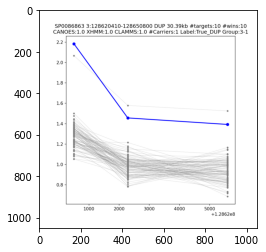

In [14]:
i=30941+1
img = loadImg(cnv_path_list[i][0])
print(cnv_path_list[i][1])
showImg(img)

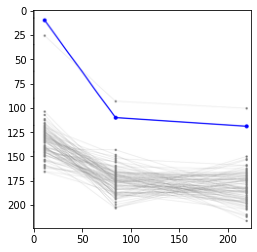

In [15]:
img = resizeCropImg(img, img_width, img_height)
showImg(img)

In [114]:
def process_line(line):
    line = line.strip('\n')
    line = line.split('\t')
    return line
        
def norm_img_label(img_np, label):
    # Change to float datatype
    img_np = img_np.astype('float32')
    # Scale the data to lie between 0 to 1
    img_np /= 255
    # Change the labels from integer to categorical data
#     label_one_hot = to_categorical(label, num_classes)
    label_one_hot = label
    return img_np, label_one_hot

def generate_arrays_from_file(path, label, batch_size):
    batch_count = 0
    img_file_list, img_np_list, label_one_hot_list = [], [], []
    while True:
#         with open(path) as f:        
        for line in zip(path, label):
            batch_count += 1
            # load img and label path from file
#             img_file, label = process_line(line)
            img_file, label = line
            # load img
            img = loadImg(img_file)
            img = resizeCropImg(img, img_width, img_height)
            img_np = img2Numpy(img)
            # normlization
            img_np, label_one_hot = norm_img_label(img_np, label) 

            # append
            img_file_list.append(img_file)
            img_np_list.append(img_np)
            label_one_hot_list.append(label_one_hot)

            if batch_count >= batch_size:
                imgs_np = np.array(img_np_list, dtype='float32')
                labels_np = np.array(label_one_hot_list, dtype='float32')
                yield imgs_np, labels_np
                batch_count = 0
                img_file_list, img_np_list, label_one_hot_list = [], [], []                                 
#                 yield ({'img_np': img_np}, {'label': label_one_hot})
#         f.close()

In [110]:
model_name = 'MobileNet_v1'
# model_name = 'CNN_model'
# model_name = 'ResNet50'
print("Model name: %s"%model_name)
model = cnn_model(model_name, num_classes)
model.summary()

Model name: MobileNet_v1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1000)              4253864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 4,767,915
Trainable params: 4,746,027
Non-trainable params: 21,888
_________________________________________________________________


In [75]:
cnv_path_shuffled, cnv_label_one_hot_shuffled = shuffle(cnv_path_np, cnv_label_one_hot)

In [78]:
## split image arrays for splits CNVs

train_path, test_path, train_label, test_label = train_test_split(cnv_path_shuffled,
                                                                cnv_label_one_hot_shuffled,
                                                                test_size=0.2,
                                                                shuffle=True,
                                                                random_state=3)

train_path, val_path, train_label, val_label = train_test_split(train_path,
                                                              train_label,
                                                              test_size=0.25,
                                                              shuffle=True,
                                                              random_state=3) # 0.25*0.8=0.2

In [85]:
print(cnv_path_shuffled.shape, cnv_label_one_hot_shuffled.shape)
print(train_path.shape, train_label.shape)
print(val_path.shape, val_label.shape)
print(test_path.shape, test_label.shape)

(95860,) (95860, 3)
(57516,) (57516, 3)
(19172,) (19172, 3)
(19172,) (19172, 3)


In [123]:
# Fit data to model
batch_size = 50
model.fit_generator(generator = generate_arrays_from_file(train_path, train_label, batch_size),
                    validation_data = generate_arrays_from_file(val_path, val_label, batch_size),
                    steps_per_epoch=95860/batch_size,
                    epochs = 10,
                    shuffle=True,
                    workers= 1,
                    use_multiprocessing=False
                   )

Epoch 1/10
1150/1917 [================>.............] - ETA: 18:59 - loss: 0.2522 - accuracy: 0.8859 - f1_m: 0.8856 - precision_m: 0.8939 - recall_m: 0.8776

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  TypeError: 'numpy.float32' object is not iterable
Traceback (most recent call last):

  File "/data/rt2776/miniconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 243, in __call__
    ret = func(*args)

  File "/data/rt2776/miniconda3/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 309, in wrapper
    return func(*args, **kwargs)

  File "/data/rt2776/miniconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 785, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/data/rt2776/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 801, in wrapped_generator
    for data in generator_fn():

  File "<ipython-input-114-fcea20cfe149>", line 21, in generate_arrays_from_file
    for line in zip(path, label):

TypeError: 'numpy.float32' object is not iterable


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
  (1) Invalid argument:  TypeError: 'numpy.float32' object is not iterable
Traceback (most recent call last):

  File "/data/rt2776/miniconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 243, in __call__
    ret = func(*args)

  File "/data/rt2776/miniconda3/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 309, in wrapper
    return func(*args, **kwargs)

  File "/data/rt2776/miniconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 785, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/data/rt2776/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 801, in wrapped_generator
    for data in generator_fn():

  File "<ipython-input-114-fcea20cfe149>", line 21, in generate_arrays_from_file
    for line in zip(path, label):

TypeError: 'numpy.float32' object is not iterable


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[Shape/_6]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_28067]

Function call stack:
train_function -> train_function


## Normalization

In [ ]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = combined_img_np.shape[1:]
input_shape = (nRows, nCols, nDims)
print("The shape of input tensor:",input_shape)

In [ ]:
# Change to float datatype
combined_img = combined_img_np.astype('float32')

# Scale the data to lie between 0 to 1
combined_img /= 255

# Change the labels from integer to categorical data
combined_label_one_hot = to_categorical(combined_label)

In [ ]:
# Find the unique numbers from the train labels
classes = np.unique(combined_label)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)
print("4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")

In [ ]:
#np.where(train_label==0)

In [ ]:
item = 100 
item = random.randint(0,len(combined_label))
print(combined_label[item])
showImg(combined_img[item])

## Split dataset into training(80%) and testing(20%) dataset

In [ ]:
## split image arrays
if project_name == 'rare_entire_cnv' or project_name == 'rare_entire_del' or project_name == 'rare_entire_dup':
    train_img, test_img, train_label, test_label, train_cnv_info_df, test_cnv_info_df = train_test_split(combined_img_np,
                                                                                                        combined_label_one_hot,
                                                                                                        combined_cnv_info_df,
                                                                                                        test_size=0.2,
                                                                                                        shuffle=True,
                                                                                                        random_state=3)

    train_img, val_img, train_label, val_label, train_cnv_info_df, val_cnv_info_df = train_test_split(train_img,
                                                                                                      train_label,
                                                                                                      train_cnv_info_df,
                                                                                                      test_size=0.25,
                                                                                                      shuffle=True,
                                                                                                      random_state=3) # 0.25*0.8=0.2

In [ ]:
combined_img_np.shape, train_img.shape, val_img.shape, test_img.shape

In [ ]:
combined_label_one_hot.shape, train_label.shape, val_label.shape, test_label.shape

In [ ]:
## split image arrays for splits CNVs
if project_name == 'rare_split_del' or project_name == 'rare_split_dup':
    train_img, test_img, train_label, test_label = train_test_split(combined_img_np,
                                                                    combined_label,
                                                                    test_size=0.2,
                                                                    shuffle=True,
                                                                    random_state=3)

    train_img, val_img, train_label, val_label = train_test_split(train_img,
                                                                  train_label,
                                                                  test_size=0.25,
                                                                  shuffle=True,
                                                                  random_state=3) # 0.25*0.8=0.2

In [ ]:
i=random.randrange(len(train_img))
## if the the images are different, then it means it has been shuffled.
print("Label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")
showImg(combined_img_np[i]),combined_label_one_hot[i],combined_cnv_info_df.iloc[i,:],combined_cnv_info_df.iloc[i,20]

In [ ]:
i=random.randrange(len(train_img))
## if the the images are different, then it means it has been shuffled.
print("Label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")
showImg(train_img[i]),train_label[i],train_cnv_info_df.iloc[i,:],train_cnv_info_df.iloc[i,20]

In [ ]:
test_img.shape, test_label.shape

### Train the deep nerual model by Hold-out validation
- Ref: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529

In [ ]:
model_dir = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/'

In [ ]:
model_name='CNN_model'
print("Model name: %s"%model_name)
model = cnn_model(model_name, nClasses)
model.summary()

In [ ]:
print("Training by a common CNN model ...")
batch_size = 30
epochs = 50
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc]) ## easy to exhaust the memory by using "validation_split = 0.2"

loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)
print("Model_name:",model_name)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

In [ ]:
# output model metrics
output_file = model_dir + "model_metrics_" + model_name + ".txt"
output_model_metrics(model_name, loss, accuracy, f1_score, precision, recall, output_file)

- MobileNet v1

In [ ]:
model_name='MobileNet_v1'
print("Model name: %s"%model_name)
model = cnn_model(model_name, nClasses)
model.summary()
showDateTime()

In [ ]:
print("Training by MobileNet_v1 model ...")
batch_size = 60
epochs = 50
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc])
## easy to exhaust the memory by using "validation_split = 0.2"
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)

In [ ]:
print("Model_name:",model_name)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

In [ ]:
# output model metrics
output_file = model_dir + "model_metrics_" + model_name + ".txt"
output_model_metrics(model_name, loss, accuracy, f1_score, precision, recall, output_file)
showDateTime()

- ResNet 50

In [ ]:
model_name='ResNet50'
print("Model name: %s"%model_name)
model = cnn_model(model_name, nClasses)
model.summary()

In [ ]:
print("Training by ResNet50 model ...")
batch_size = 20
epochs = 50
model_file = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
                     
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)
history = model.fit(train_img, train_label,
                    batch_size=batch_size, 
                    epochs=epochs, verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc])
## easy to exhaust the memory by using "validation_split = 0.2"
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)
print("Model_name:",model_name)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

In [ ]:
# output model metrics
output_file = model_dir + "model_metrics_" + model_name + ".txt"
output_model_metrics(model_name, loss, accuracy, f1_score, precision, recall, output_file)

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.ylim(0.7, 1)
plt.title(project_name+' accuracy curves',fontsize=16)

### ROC curve

In [ ]:
print(project_name, model_name)
model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

In [ ]:
## Load pre-calculated model
custom_objects = {"f1_m":f1_m, "precision_m":precision_m, "recall_m":recall_m}

model_name = 'CNN_model'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
common_cnn_model = keras.models.load_model(model_path, custom_objects=custom_objects)

model_name = 'MobileNet_v1'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
MobileNet_model = keras.models.load_model(model_path, custom_objects=custom_objects)

model_name = 'ResNet50'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
ResNet50_model = keras.models.load_model(model_path, custom_objects=custom_objects)

In [ ]:
fpr_MobileNet, tpr_MobileNet, thresholds_MobileNet, auc_MobileNet = pred_roc_data(MobileNet_model, test_img, test_label)
fpr_ResNet50,  tpr_ResNet50,  thresholds_ResNet50,  auc_ResNet50  = pred_roc_data(ResNet50_model,  test_img, test_label)
fpr_common_cnn,tpr_common_cnn,thresholds_common_cnn,auc_common_cnn= pred_roc_data(common_cnn_model,test_img, test_label)

In [ ]:
plt.figure(1,dpi=150)
plt.tick_params(labelsize="x-large")
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_MobileNet, tpr_MobileNet, label='MobileNet_v1(area = {:.3f})'.format(auc_MobileNet))
plt.plot(fpr_ResNet50,  tpr_ResNet50,  label='ResNet50 (area = {:.3f})'.format(auc_ResNet50))
plt.plot(fpr_common_cnn,tpr_common_cnn,label='Common CNN (area = {:.3f})'.format(auc_common_cnn))
plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve',fontsize="xx-large")
plt.legend(loc='best',fontsize="large")
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2,dpi=150)
plt.tick_params(labelsize="x-large")
plt.xlim(0, 0.3)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_MobileNet, tpr_MobileNet, label='MobileNet_v1(area = {:.3f})'.format(auc_MobileNet))
plt.plot(fpr_ResNet50,  tpr_ResNet50,  label='ResNet50 (area = {:.3f})'.format(auc_ResNet50))
plt.plot(fpr_common_cnn,tpr_common_cnn,label='Common CNN (area = {:.3f})'.format(auc_common_cnn))
plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve (zoomed in at top left)',fontsize="xx-large")
plt.legend(loc='best',fontsize="large")
plt.show()

- Calculate model metrics (F1-score). TODO: calcualte f1-score in different categories

In [ ]:
print("Model_name: common_cnn_model")
loss, accuracy, f1_score, precision, recall = common_cnn_model.evaluate(test_img, test_label)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

In [ ]:
print("Model_name: MobileNet")
loss, accuracy, f1_score, precision, recall = MobileNet_model.evaluate(test_img, test_label)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

In [ ]:
print("Model_name: ResNet50")
loss, accuracy, f1_score, precision, recall = ResNet50_model.evaluate(test_img, test_label)
print("loss:",loss, "\naccuracy:",accuracy, "\nf1_score:",f1_score, "\nprecision:",precision, "\nrecall:",recall)

In [ ]:
i=random.randrange(len(test_img))
#i=random.choice(test_output_df[test_output_df['Pred_status']=='Wrong'].index)
showImg(test_img[i]), 
print(test_label[i],  test_cnv_info_df.iloc[i,:])

In [ ]:
print(project_name)
time_stamp = datetime.datetime.now()
time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
print(time_str)

- Confusion matrix

In [ ]:
#from sklearn.metrics import classification_report
def show_confusion_matrix(validations, predictions, lables):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4),dpi=150)
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=lables,
                yticklabels=lables,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [ ]:
## Load pre-calculated model
custom_objects = {"f1_m":f1_m, "precision_m":precision_m, "recall_m":recall_m}
nClasses = 4

model_name = 'CNN_model'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
common_cnn_model = keras.models.load_model(model_path, custom_objects=custom_objects)

model_name = 'MobileNet_v1'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
MobileNet_model = keras.models.load_model(model_path, custom_objects=custom_objects)

model_name = 'ResNet50'
model_path = model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"
print("Loading %s ... from %s"%(model_name, model_path))
ResNet50_model = keras.models.load_model(model_path, custom_objects=custom_objects)

In [ ]:
test_pred = MobileNet_model.predict(test_img)

In [ ]:
test_label

In [ ]:
print("\n--- Confusion matrix for test data ---\n")
print("4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")
if nClasses == 3:
    labels = ['DEL', 'DIP', 'DUP']
if nClasses == 4:
    labels = ['DEL', 'Not_DEL', 'Not_DUP', 'DUP']
    
test_pred = MobileNet_model.predict(test_img)
# Take the class with the highest probability from the test predictions
max_pred_test = np.argmax(test_pred, axis=1)
max_label_test = np.argmax(test_label, axis=1)
show_confusion_matrix(max_label_test, max_pred_test, labels)

print("\n--- Classification report for test data ---\n")
print(classification_report(max_label_test, max_pred_test))

In [ ]:
# output model metrics
model_metric_list = []
model_metric_list.append(model_name)
model_metric_list.append(["loss:", loss]) 
model_metric_list.append(["accuracy:", accuracy])
model_metric_list.append(["precision:", precision])
model_metric_list.append(["recall:", recall])
model_metric_list.append(["f1_score:", f1_score])
output_to_file(model_metric_list, model_dir + "model_metrics_" + model_name + ".txt")

## K-fold cross validation

In [ ]:
model_dir = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/'
model_name='MobileNet_v1'

seed = 6666
num_folds = 5
# Define the K-fold Cross Validator
#kfold = KFold(n_splits=num_folds, shuffle=True)
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

In [ ]:
VALIDATION_ACCURACY, VALIDATION_LOSS = [], []
tpr_list, tpr_interp_list, fpr_list, auc_list = [], [], [], []
mean_fpr = np.linspace(0, 1, 100)

nClasses = 3

# K-fold Cross Validation model evaluation

train_val_img, test_img, train_val_label, test_label = train_test_split(combined_img,
                                                                      combined_label,
                                                                      test_size=0.2,
                                                                      shuffle=True,
                                                                      random_state=seed)
test_label_one_hot = to_categorical(test_label)

fold_num = 1
for train_index, val_index in kfold.split(train_val_img, train_val_label):
    print('------------------------------------------------------------------------')
    showDateTime()
    print('Training for fold %d ...'%fold_num)
    print("num_index",len(train_index), len(val_index))
   
    train_img  = train_val_img[train_index]
    train_label_one_hot = to_categorical(train_val_label[train_index])
    
    val_img  = train_val_img[val_index]
    val_label_one_hot = to_categorical(train_val_label[val_index])
    
#     train_img, val_img, train_label_one_hot, val_label_one_hot = train_test_split(train_val_img,
#                                                                   train_val_label_one_hot,
#                                                                   test_size=0.25,
#                                                                   shuffle=True,
#                                                                   random_state=seed)
    
    print("Combined:", combined_img.shape, combined_label_one_hot.shape)
    print("Train:", train_img.shape, train_label_one_hot.shape)
    print("Validation:", val_img.shape, val_label_one_hot.shape)
    print("Test:", test_img.shape, test_label_one_hot.shape)
    
    # CREATE and COMPILE NEW MODEL
    model_name='MobileNet_v1'
    print("Model name: %s"%model_name)
    model = cnn_model(model_name, nClasses)
    
    model_file = model_dir + project_name + "_" + model_name + "_fold" +str(fold_num)+".h5"
    
    # CREATE CALLBACKS
    batch_size = 100
    epochs = 50
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    checkpoint = ModelCheckpoint(model_file,
                         monitor='val_accuracy',
                         mode='max', 
                         verbose=1, 
                         save_best_only=True)
    callbacks_list = [checkpoint]
    
    # FIT THE MODEL
    print("Fit the model ...")
    history = model.fit(train_img, train_label_one_hot,
                        batch_size=batch_size, 
                        epochs=epochs, verbose=1, 
                        validation_data=(val_img, val_label_one_hot), 
                        callbacks=[es, checkpoint])
    ## easy to exhaust the memory by using "validation_split = 0.2"

    # LOAD BEST MODEL to evaluate the performance of the model
    print("Load weights...")
    model.load_weights(model_file)

    print("Evaluate ...")
    results = model.evaluate(test_img, test_label_one_hot)
    results = dict(zip(model.metrics_names,results))
    print(results)
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    
    fpr_roc, tpr_roc, thresholds_roc, auc_roc = pred_roc_data(model, test_img, test_label_one_hot)    
#     plt.plot(fpr_roc, tpr_roc, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (fold_num, auc_roc))

    #tpr_list.append(interp(mean_fpr, fpr, tpr))
    interp_tpr = np.interp(mean_fpr, fpr_roc, tpr_roc)
    interp_tpr[0] = 0.0
    
#     print("test data:",test_img.shape, test_label_one_hot.shape)
#     print("tpr, fpr, auc size:",tpr_roc.shape,fpr_roc.shape, auc_roc.shape)
    tpr_list.append(tpr_roc)
    tpr_interp_list.append(interp_tpr)
    fpr_list.append(fpr_roc)
    auc_list.append(auc_roc)
#     print("list size:",len(tpr_list),len(fpr_list), len(auc_list))
    
    tf.keras.backend.clear_session()
    fold_num += 1



In [ ]:
plt.figure(1,dpi=150)
plt.tick_params(labelsize="x-large")
plt.plot([0, 1], [0, 1], 'k--')

for fold_num in range(num_folds):
    plt.plot(fpr_list[fold_num], tpr_list[fold_num], lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (fold_num, auc_list[fold_num]))
    
mean_tpr = np.mean(tpr_interp_list, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(auc_list)
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

## plot std
# std_tpr = np.std(tpr_list, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                 label=r'$\pm$ 1 std. dev.')


plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve',fontsize="xx-large")
plt.legend(loc='best',fontsize="large")
plt.show()

    
showDateTime()

In [ ]:
image_file = model_dir + project_name + "_" + model_name + "_roc_curve.png"
plt.savefig(image_file)
#plt.close() 

In [ ]:
plt.figure(2,dpi=150)
plt.tick_params(labelsize="x-large")
plt.xlim(0, 0.3)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')

for fold_num in range(num_folds):
    plt.plot(fpr_list[fold_num], tpr_list[fold_num], lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (fold_num, auc_list[fold_num]))
    
mean_tpr = np.mean(tpr_interp_list, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(auc_list)
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve (zoomed in at top left)',fontsize="xx-large")
plt.legend(loc='best',fontsize="large")
plt.show()
image_zoom_file = model_dir + project_name + "_" + model_name + "_roc_curve_zoom.png"
plt.savefig(image_zoom_file)
plt.close

## Precision

In [ ]:
test_pred = model1.predict(test_img)

In [ ]:
test_output_df = copy.deepcopy(test_cnv_info_df)
test_output_df.shape

In [ ]:
test_output_df.insert(test_output_df.shape[1], 'Prob_True', "")
test_output_df.insert(test_output_df.shape[1], 'Prob_False', "")
test_output_df.insert(test_output_df.shape[1], 'Prediction', "")
test_output_df.insert(test_output_df.shape[1], 'Pred_status', "")

In [ ]:
test_output_df.shape,test_pred.shape, test_cnv_info_df.shape

In [ ]:
num, correct_count = 0, 0
for i in range(len(test_pred)):
    num += 1
    test_output_df.iloc[i,test_output_df.columns.get_loc('Prob_False')] = test_pred[i][0]
    test_output_df.iloc[i,test_output_df.columns.get_loc('Prob_True')] = test_pred[i][1]

    if(np.argmax(test_pred[i]) == 0):
        test_output_df.iloc[i,test_output_df.columns.get_loc('Prediction')] = "Negative"
    else:
        test_output_df.iloc[i,test_output_df.columns.get_loc('Prediction')] = "Positive"
        
    if(np.argmax(test_pred[i]) == test_label[i]):
        test_output_df.iloc[i,test_output_df.columns.get_loc('Pred_status')] = "Correct"
        correct_count += 1
    else:
        test_output_df.iloc[i,test_output_df.columns.get_loc('Pred_status')] = "Wrong"
#     print(num, test_pred[i], test_label[i], pred_status)
score = correct_count/len(test_pred)
print('Accuracy for testing data: %.2f%s' % (score*100,'%'))

In [ ]:
## output to file
output_path = '/home/rt2776/cnv_espresso/output/'
test_output_df.to_csv(output_path+project_name+'_test_predict_info.csv',index=False)


In [ ]:
test_output_df[test_output_df['Pred_status']=='Wrong']

In [ ]:
test_output_df.index=range(len(test_output_df))

In [ ]:
#i=random.randrange(len(test_img))
i=random.choice(test_output_df[test_output_df['Pred_status']=='Wrong'].index)
showImg(test_img[i]), 
print(test_label[i], test_pred[i],  test_output_df.iloc[i,:])

### TODO:
- Check the performance on different size categories on test data firstly and by k-fold cross validation secondly. 

## Reference:
- Load image: https://keras.io/api/preprocessing/image/#load_img-function
- Model example: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
- Transfer learning and toy demo: https://zhuanlan.zhihu.com/p/51889181
- K-fold validation: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
- ROC curve: https://medium.com/hackernoon/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
- F1 score: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
- Generator: https://www.linkedin.com/pulse/keras-training-large-datasets-dont-fit-memory-rajat-garg/
- Generator yield: https://www.machinecurve.com/index.php/2020/04/06/using-simple-generators-to-flow-data-from-file-with-keras/#using-model-fit-using-validation-data-specified-as-a-generator